Привет. Чтобы не повторять здесь заново всё то, что мы делали в течении этих недель, я буду описывать свои действия в ходе выполнения соревнования на Kaggle, поэтому данные, некоторые действия над ними и последовательность этих действий могут несколько отличаться от того, что мы делали в курсе. Зато это будет не так скучно (я надеюсь).
<br><h3>Цели и задачи проекта</h3>
<br>На всякий случай напоминаю, что мы решаем задачу идентификации интернет-пользователей. На языке машинного обучения она формулируется как задача классификации на основе данных о посещённых сайтах и времени их посещения. Эту задачу можно отнести к обширному разделу "Fraud detection", целью которого является научиться обнаружать взломщиков. Также можно применять в целях маркетинга и анализа бизнеса.
<br><h3>Исходные данные</h3>

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from xgboost import XGBClassifier
from tqdm import tqdm_notebook

In [2]:
data_path = ('kaggle_data')
train_df = pd.read_csv(os.path.join(data_path, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(data_path, 'test_sessions.csv'),
                      index_col='session_id')

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

Изначально имеем номера сайтов и даты их посещения для каждой из сессий. Максимальная длина сессии - 10 сайтов или 30 минут, при высокой продолжительности или окончании сессии она прерывается и всё заполняется NaN. В тренировочном датасете имеем 253561 наблюдений, в тестовой выборке - 82797. Также есть информация о названиях сайтов.
<br>Посмотрим на распределение целевой переменной.

0.00905896411514389


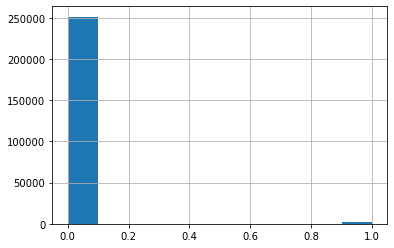

In [5]:
print(train_df.target.sum() / len(train_df))
train_df.target.hist()

Меньше 1% наших сессий относятся к Алисе, поэтому при оценке качество важно смотреть не на accuracy, а на метрики, более стойкие к несбалансированности классов - precision/recall/f1-score. ROC-AUC, предлагаемая в соревновании, также неплохо подходит.
<br>Для первичного анализа объединим тренировочную и тестовую выборки.

In [6]:
train_test_df = pd.concat([train_df, test_df])

C:\Users\Vanster\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Считаем названия сайтов.

In [7]:
site_dict = pd.read_pickle(os.path.join(data_path, 'site_dic.pkl'))
len(site_dict)

48371

<h3>Обработка признаков</h3>
<br>Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.

In [8]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_sites.shape

(336358, 10)

Преобразуем данные о посещённых сайтах с помощью Tf-Idf с применением n-грам.

In [9]:
def df_vectorizer_sparse(dataframe, stop_word=u'0'):
    tokenizer=lambda x: x.split(' ')
    
    v = TfidfVectorizer(tokenizer=tokenizer, stop_words=[stop_word], ngram_range=(1, 2))
    
    dataframe_str = [' '.join(str(i) for i in x) for x in np.array(dataframe)]
    csr_session_sites = v.fit_transform(dataframe_str)
    
    return csr_session_sites

In [10]:
train_test_sparse = df_vectorizer_sparse(train_test_df_sites)

Разделим данные обратно и разобьём тренировочные на тренировочные и валидационные. При этом для разбиения просто отсечём 30% данных из конца, так как именно такие данные использовались для валидации в предыдущих заданиях.

In [11]:
X_train_sparse = train_test_sparse[:train_df.shape[0], :]
X_test_sparse = train_test_sparse[train_df.shape[0]:, :]
y = train_df['target'].values

In [12]:
train_size = int(0.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_size, :], y[:train_size]
X_valid, y_valid  = X_train_sparse[train_size:, :], y[train_size:]

In [13]:
pd.Series(y_train).value_counts()

0    175887
1      1605
dtype: int64

In [14]:
pd.Series(y_valid).value_counts()

0    75377
1      692
dtype: int64

Разбиение стратифицированно.

<h3>Baseline</h3>
<br>Посмотрим, что можно выжать из этих данных с значениями по умолчанию популярных моделей.

In [15]:
sgd_clf = SGDClassifier(loss='log', random_state=42, n_jobs=-1, alpha=3e-5, class_weight='balanced')
sgd_clf.fit(X_train, y_train)
sgd_base = sgd_clf.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, sgd_base), 5)

0.94798

In [16]:
logit = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1, C=1, class_weight='balanced')
logit.fit(X_train, y_train)
logit_base = logit.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, logit_base), 5)

0.95129

In [17]:
xgb_clf = XGBClassifier(n_estimators=200)
xgb_clf.fit(X_train, y_train)
xgb_base = xgb_clf.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, xgb_base), 5)

0.90968

Сходу получаем неплохое значение метрики, и это означает, что полученное признаковое описание достаточно хорошее. Интересно, что более простые линейные модели работают здесь лучше, чем такой непростой алгоритм как градиентный бустинг.

<h3>Построение новых признаков</h3>

In [18]:
sites = ['site%d' % i for i in range(1, 11)]
times = ['time%d' % i for i in range(1, 11)]
diff_times = ['diff_time%d' % i for i in range(1, 10)]

In [19]:
for col in times:
    train_test_df[col] = pd.to_datetime(train_test_df[col])

train_test_df['start_sess_year'] = train_test_df['time1'].dt.year
train_test_df['start_sess_month'] = train_test_df['time1'].dt.month
train_test_df['start_sess_weekday'] = train_test_df['time1'].dt.weekday
train_test_df['start_sess_day'] = train_test_df['time1'].dt.day
train_test_df['start_sess_hour'] = train_test_df['time1'].dt.hour

train_test_df['sess_length'] = (train_test_df[times].max(axis=1) - train_test_df['time1']).dt.seconds.astype(int)

df_sites = np.asarray(train_test_df[sites].fillna(0))
train_test_df['unique_sites'] = [np.count_nonzero(i) for i in map(np.unique, df_sites)]

tr_t_array = np.array(train_test_df[times])
np_sites = np.array(train_test_df_sites)
np_diff_times = (np.diff(tr_t_array, axis=1) * 1e-9).astype('int')

train_test_df['mean_sess_time'] = np.round(np.mean((np.diff(tr_t_array, axis=1) * 1e-9).astype('int'), axis=1), 4)

for idx, col in enumerate(diff_times):
    train_test_df[col] = np_diff_times.T[idx]

Google является очень показательным сайтом, как показали предыдущие задачи, поэтому имеет смысл отдельно найти все сайты с подстрокой 'google'.

In [20]:
google_sites = []
for key, value in site_dict.items():
    if u'google.' in key:
        google_sites.append(value)

Добавим признаки, связанные с посещением популярных сайтов.

In [21]:
counts_d = train_test_df[sites].stack().value_counts().tolist()
sites_d = train_test_df[sites].stack().value_counts().index.tolist()

top30_sites = [x[0] for x in zip(sites_d[:30], counts_d[:30])]
top20_sites = [x[0] for x in zip(sites_d[:20], counts_d[:20])]
top10_sites = [x[0] for x in zip(sites_d[:10], counts_d[:10])]

train_test_df['top30_visits'] = np.sum(np.in1d(np_sites, top30_sites).reshape((np_sites.shape)).astype('int'), axis=1)
train_test_df['top20_visits'] = np.sum(np.in1d(np_sites, top20_sites).reshape((np_sites.shape)).astype('int'), axis=1)
train_test_df['top10_visits'] = np.sum(np.in1d(np_sites, top10_sites).reshape((np_sites.shape)).astype('int'), axis=1)

train_test_df['google_visits'] = np.sum(np.in1d(np_sites, google_sites).reshape((np_sites.shape)).astype('int'), axis=1)

top30_in_sess = np.in1d(np_sites, top30_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top30_aver_time'] = np.mean(np.multiply(top30_in_sess, np_diff_times), axis=1)
top20_in_sess = np.in1d(np_sites, top20_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top20_aver_time'] = np.mean(np.multiply(top20_in_sess, np_diff_times), axis=1)
top10_in_sess = np.in1d(np_sites, top10_sites).reshape((np_sites.shape)).astype('int')[:, :-1]
train_test_df['top10_aver_time'] = np.mean(np.multiply(top10_in_sess, np_diff_times), axis=1)

Добавим количество переключений между сайтами больше 3 секунд.

In [22]:
train_test_df['slow_click'] = np.sum((((np.diff(tr_t_array, axis=1) * 1e-9).astype('int')) > 3).astype('int'), axis = 1)

Некоторые признаки могут быть вычислены моделью самостоятельно, но если их добавить вручную, то обучение пройдёт легче, так что сделаем это.

In [23]:
train_test_df['year_month'] = train_test_df['time1'].apply(lambda x: 100 * x.year + x.month)
train_test_df['evening_start'] = train_test_df['start_sess_hour'].apply(lambda x: 1 if x > 19 else 0)
train_test_df['morning_start'] = train_test_df['start_sess_hour'].apply(lambda x: 1 if x < 11 else 0)

In [24]:
features = list(set(train_test_df.columns.tolist()) - set(times) - set(sites) - set(['target']))
features

['diff_time4',
 'diff_time5',
 'morning_start',
 'unique_sites',
 'diff_time6',
 'top10_aver_time',
 'year_month',
 'diff_time3',
 'start_sess_weekday',
 'top20_visits',
 'top10_visits',
 'start_sess_month',
 'diff_time1',
 'start_sess_hour',
 'top30_visits',
 'start_sess_year',
 'diff_time9',
 'slow_click',
 'diff_time8',
 'diff_time2',
 'google_visits',
 'top20_aver_time',
 'sess_length',
 'start_sess_day',
 'mean_sess_time',
 'diff_time7',
 'evening_start',
 'top30_aver_time']

In [25]:
tokenizer = lambda x: x.split(' ')
tfidf = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1, 1))
str_times = [' '.join(str(i) for i in x) for x in np_diff_times]
train_test_time_diff_sparse = tfidf.fit_transform(str_times)

X_train_time_diff_sparse = train_test_time_diff_sparse[:train_df.shape[0], :]
X_test_time_diff_sparse = train_test_time_diff_sparse[train_df.shape[0]:, :]

In [26]:
X_train_time_diff = X_train_time_diff_sparse[:train_size, :]
X_valid_time_diff  = X_train_time_diff_sparse[train_size:, :]

<h3>Визуальный анализ данных</h3>

In [27]:
train_fe = train_test_df[:train_df.shape[0]]
test_fe = train_test_df[train_df.shape[0]:]

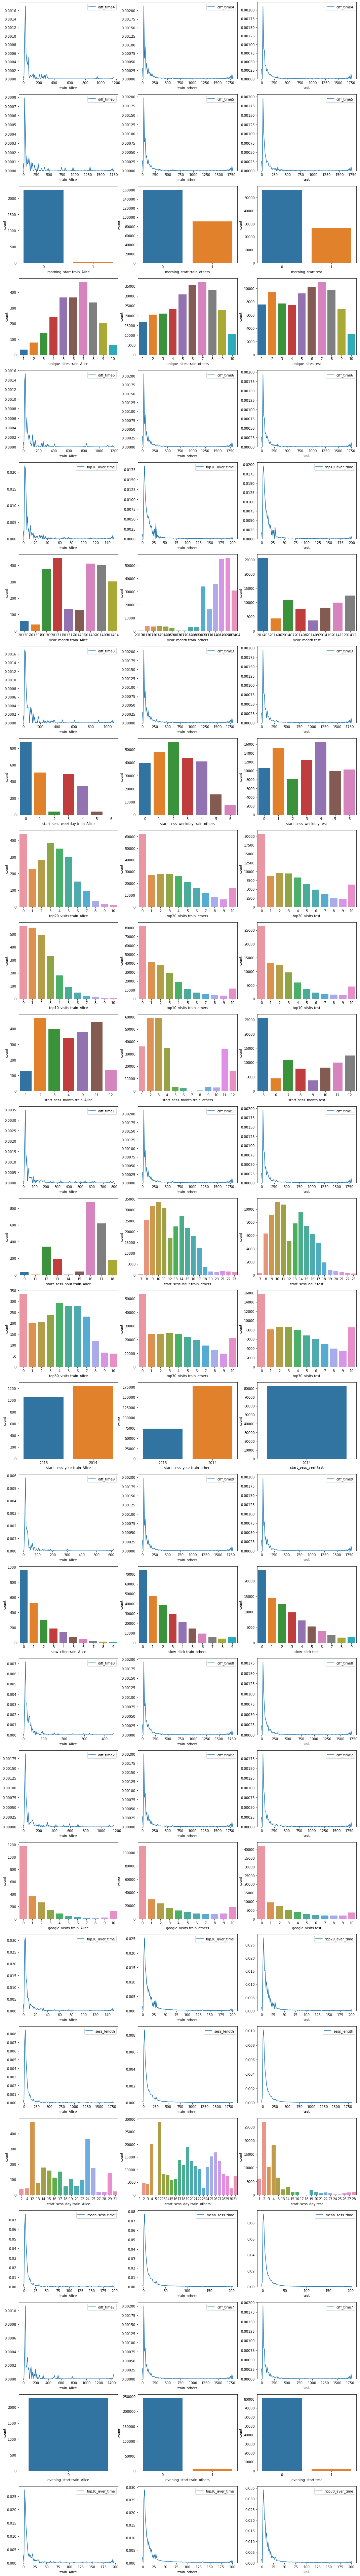

In [28]:
fig, axes = plt.subplots(nrows=len(features), ncols=3, figsize=(18, len(features)*5))

for idx in range(len(features)):
    if len(train_test_df[features[idx]].unique()) > 30:
        plt.subplot(len(features), 3, idx*3+1)
        ax = sns.kdeplot(train_fe[features[idx]][train_fe['target'] == 1])
        ax.set_xlabel('train_Alice') 

        plt.subplot(len(features), 3, idx*3+2)
        ax = sns.kdeplot(train_fe[features[idx]][train_fe['target'] == 0])
        ax.set_xlabel('train_others') 

        plt.subplot(len(features), 3, idx*3+3)
        ax = sns.kdeplot(test_fe[features[idx]])
        ax.set_xlabel('test')
    else:
        plt.subplot(len(features), 3, idx*3+1)
        ax = sns.countplot(train_fe[features[idx]][train_fe['target'] == 1])
        ax.set_xlabel(str(features[idx]) + ' train_Alice') 

        plt.subplot(len(features), 3, idx*3+2)
        ax = sns.countplot(train_fe[features[idx]][train_fe['target'] == 0])
        ax.set_xlabel(str(features[idx]) + ' train_others') 

        plt.subplot(len(features), 3, idx*3+3)
        ax = sns.countplot(test_fe[features[idx]])
        ax.set_xlabel(str(features[idx]) + ' test')

Выберем интересные в первом приближении признаки, разделим их на численные и категориальные. Интересность будем определять по тому, насколько данные для Алисы отличается от данных не для Алисы.

In [29]:
cat_features = [
 'start_sess_day',
 'start_sess_month',
 'start_sess_year',
 'start_sess_weekday',
 'evening_start',
 'year_month',
 'morning_start',
 'start_sess_hour'
 ]
num_features = [
 'mean_sess_time',
 'sess_length',
 'top10_visits',
 'top20_visits',
 'top30_visits',
 'top10_aver_time',
 'top20_aver_time',
 'top30_aver_time',
 'slow_click',
 'google_visits',
 'unique_sites'
]

Предобработаем отобранные признаки и добавим в выборку.

In [30]:
ohe = OneHotEncoder()
X_train_test_cat_fe = ohe.fit_transform(train_test_df[cat_features])
X_train_cat_fe = X_train_test_cat_fe[:train_df.shape[0], :]
X_test_cat_fe = X_train_test_cat_fe[train_df.shape[0]:, :]

In [31]:
scaler = StandardScaler()
X_train_test_num_fe = scaler.fit_transform(train_test_df[num_features])
X_train_num_fe = X_train_test_num_fe[:train_df.shape[0], :]
X_test_num_fe = X_train_test_num_fe[train_df.shape[0]:, :]

In [32]:
X_train_fe = hstack((X_train_cat_fe, X_train_num_fe))
X_test_fe = hstack((X_test_cat_fe, X_test_num_fe))

X_train_sparse_fe = hstack((X_train_sparse, X_train_fe, X_train_time_diff_sparse))
X_test_sparse_fe = hstack((X_test_sparse, X_test_fe, X_test_time_diff_sparse))

X_tr_fe = X_train_fe.toarray()[:train_size, :]
X_v_fe = X_train_fe.toarray()[train_size:, :]

X_train_fe = hstack((X_train, X_tr_fe, X_train_time_diff))
X_valid_fe = hstack((X_valid, X_v_fe, X_valid_time_diff))

<h3>Построение модели</h3>
<br>Возьмём всё ту же логистическую регрессию, которая хорошо себя зарекомендовала и быстро тренируется, благодаря чему можно провести кросс-валидацию до выхода на пенсию.

In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
%%time
logit_c_values = np.logspace(-2, 1, 10)

logit_cv = LogisticRegressionCV(Cs=logit_c_values, random_state=42, n_jobs=-1,
                                cv=skf, class_weight='balanced', scoring='roc_auc')
logit_cv.fit(X_train_sparse_fe, y)

Wall time: 5min 50s


C:\Users\Vanster\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegressionCV(Cs=array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     n_jobs=-1, random_state=42, scoring='roc_auc')

(0.9924722284995635, 2.154434690031882)


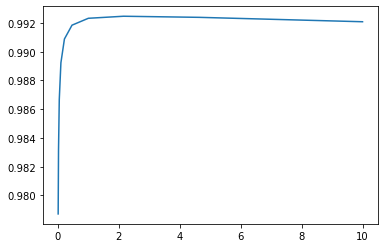

In [35]:
logit_mean_cv_scores = logit_cv.scores_[1].mean(axis=0)
mean_cvs_and_cs = zip(logit_mean_cv_scores, logit_cv.Cs_)
mean_cvs_and_cs = sorted(mean_cvs_and_cs, key=lambda x: x[0], reverse=True)
print(mean_cvs_and_cs[0])
plt.plot(logit_c_values, logit_mean_cv_scores)

In [36]:
logit = LogisticRegression(multi_class='ovr', random_state=42, n_jobs=-1, C=1.0, class_weight='balanced')
logit.fit(X_train_fe, y_train)
logit_valid_pred_proba = logit.predict_proba(X_valid_fe)[:, 1]
round(roc_auc_score(y_valid, logit_valid_pred_proba),5)

0.99064

Некоторые модификации и прочие усилия позволили мне вывести это решение на 0.95 на лидерборде. Много чего не работало, итоговая отправка это ансамбль из различным образом обученных логистических регрессий.

# Итоги

Полученная модель с достаточно высокой точностью решает полученную задачу идентификации Алины. При этом небольшими усилиями её можно модифицировать и под многоклассовый случай. Высокое качество по ROC-AUC показывает, что наша модель неплохо ранжирует данные по уверенности в ответе. Это означает, что если мы не хотим ни в коем случае допустить такого, что произойдёт взлом Алисы, то уже при уверенности алгоритма менее чем в 90% можно начинать беспокоиться и принимать какие-то меры, таким образом максимизируя recall. Если же меры принимать дорого и мы хотим это делать только когда уверены, то наоборот, можно реагировать только при уверенности менее чем в 25%. Тогда получим хороший precision.
<br>Из минусов использования этой модели стоит отметить то, что для её работы всё же необходима какая-то история действий, и до её срабатывания злоумышленник может успеть сделать что-то плохое. Также стоит понимать, что она актуальна для ограниченного фиксированного числа пользователей, иначе с регистрацией каждого нового модель придётся перетренировывать. С этой точки зрения больше подошёл бы классификатор на странное и привычное поведение или детектор аномалий.